In [1]:
from typing import List
from copy import deepcopy

import ase
from ase import Atoms
from ase.calculators.lj import LennardJones
from ase.io import Trajectory
from ase.calculators.calculator import Calculator, all_changes

import numpy as np
import matplotlib.pyplot as plt

In [2]:
atoms = Atoms('N2')

In [3]:
atoms.positions

array([[0., 0., 0.],
       [0., 0., 0.]])

In [4]:
def sample_diatomic_distances(
    atoms_str: str = 'N2', 
    dist_range: tuple = (1.1, 3), 
    n: int = 100) -> List[ase.Atoms]:     
    """Create a trajectory of a diatomic system with linearly sampled distances
    atoms_str: ase specification of diatomic
    dist_range: (angsroms) range of distances to sample
    n: number of samples
    """
    atoms = Atoms(atoms_str)
    trajectory = []
    x_vals = np.linspace(*dist_range, n)
    for x in x_vals: 
        atoms = atoms.copy()
        atoms.set_positions([[0,0,0], [x, 0, 0]])
        trajectory.append(atoms)
    return trajectory

In [5]:
def apply_calculator(
    calc: ase.calculators.calculator.Calculator, 
    traj: List[ase.Atoms]) -> List[Atoms]:
    """Run a calculator on every atoms object in a list"""

    traj = deepcopy(traj)
    for atoms in traj: 
        atoms.calc = calc
        atoms.get_forces()
    return traj

In [6]:
lj1, lj2  = LennardJones(sigma=1, eps=1), LennardJones(sigma=1, epsilon=1.1)

In [7]:
traj_base = sample_diatomic_distances()
traj_lj1  = apply_calculator(lj1, traj_base)
traj_lj2  = apply_calculator(lj2, traj_base)

In [8]:
traj_lj1[0].get_forces()

array([[-1.58809539,  0.        ,  0.        ],
       [ 1.58809539,  0.        ,  0.        ]])

In [9]:
traj_lj1[0].get_potential_energy()

-0.9778930076294439

In [10]:
traj_lj1[0].calc.results

{'energy': -0.9778930076294439,
 'energies': array([-0.4889465, -0.4889465]),
 'free_energy': -0.9778930076294439,
 'forces': array([[-1.58809539,  0.        ,  0.        ],
        [ 1.58809539,  0.        ,  0.        ]])}

In [11]:
def extract_diatomic_quantities(traj): 
    x = np.zeros(len(traj))
    energies = np.zeros(len(traj))
    forces = np.zeros(len(traj))
    for i, atoms in enumerate(traj):
        x[i] = atoms.positions[1, 0]
        energies[i] = atoms.get_potential_energy()
        forces[i] = atoms.get_forces()[0,0]
    return x, energies, forces

In [12]:
x_l1, e_l1, f_l1 = extract_diatomic_quantities(traj_lj1)
x_l2, e_l2, f_l2 = extract_diatomic_quantities(traj_lj2)

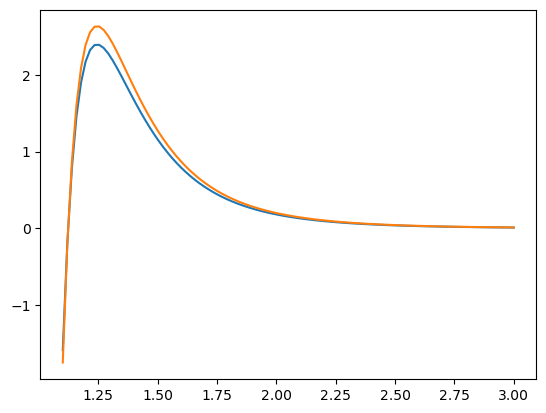

In [13]:
plt.plot(x_l1, f_l1)
plt.plot(x_l2, f_l2)

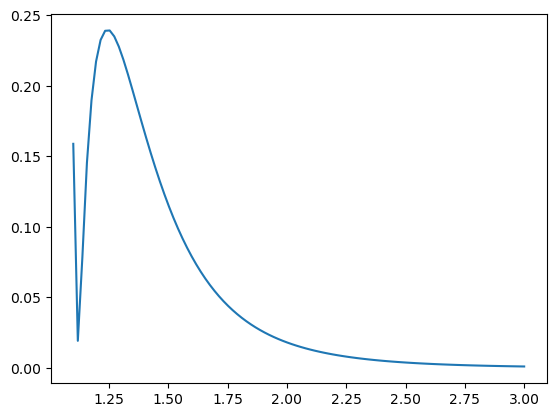

In [14]:
plt.plot(x_l1, np.abs(f_l1 - f_l2))

## Ensemble Class

In [77]:
class EnsembleCalculator(Calculator): 
    implemented_properties = ['energy', 'forces', 'forces_std']
    
    def __init__(self, 
                 calculators: List[Calculator], **kwargs):

        Calculator.__init__(self, **kwargs)
        self.calculators = calculators
        self.num_calculators = len(calculators)

    def calculate(self,
                  atoms: ase.Atoms=None, 
                  properties=None, 
                  system_changes=all_changes):
        super().calculate(atoms, system_changes=system_changes)
        
        # create arrays for energy and forces 
        results = {
            'energy': np.zeros(self.num_calculators),
            'forces': np.zeros((self.num_calculators, len(atoms), 3))
        }

        # compute and store energy and forces for each calculator
        for i, calc in enumerate(self.calculators): 
            calc.calculate(atoms,properties=properties,system_changes=system_changes)
            for k in results.keys(): 
                results[k][i] = calc.results[k]

        # store the force std
        results['forces_std'] = results['forces'].std(0)
        atoms.info['forces_std'] = results['forces_std']

        # average over the ensemble dimension
        for k in 'energy', 'forces':
            results[k] = results[k].mean(0)

        self.results.update(results)

In [78]:
ens = EnsembleCalculator([lj1, lj2])

In [79]:
traj_ens = apply_calculator(ens, traj_base)

In [80]:
traj_lj1[0].calc.results

{'energy': -8.673617379884035e-19,
 'energies': array([-4.33680869e-19, -4.33680869e-19]),
 'free_energy': -8.673617379884035e-19,
 'forces': array([[ 0.01094383,  0.        ,  0.        ],
        [-0.01094383,  0.        ,  0.        ]])}

In [81]:
traj_lj2[0].calc.results

{'energy': -8.673617379884035e-19,
 'energies': array([-4.33680869e-19, -4.33680869e-19]),
 'free_energy': -8.673617379884035e-19,
 'forces': array([[ 0.01203821,  0.        ,  0.        ],
        [-0.01203821,  0.        ,  0.        ]])}

In [82]:
traj_ens[10].calc.results

{'energy': -8.673617379884035e-19,
 'forces': array([[ 0.01149102,  0.        ,  0.        ],
        [-0.01149102,  0.        ,  0.        ]]),
 'forces_std': array([[0.00054719, 0.        , 0.        ],
        [0.00054719, 0.        , 0.        ]])}

In [83]:
traj_uq = [atoms.calc.results['forces_std'][0,0] for atoms in traj_ens]

In [84]:
[atoms.calc.results['forces'][0,0] for atoms in traj_ens]

[0.011491021580946895,
 0.011491021580946895,
 0.011491021580946895,
 0.011491021580946895,
 0.011491021580946895,
 0.011491021580946895,
 0.011491021580946895,
 0.011491021580946895,
 0.011491021580946895,
 0.011491021580946895,
 0.011491021580946895,
 0.011491021580946895,
 0.011491021580946895,
 0.011491021580946895,
 0.011491021580946895,
 0.011491021580946895,
 0.011491021580946895,
 0.011491021580946895,
 0.011491021580946895,
 0.011491021580946895,
 0.011491021580946895,
 0.011491021580946895,
 0.011491021580946895,
 0.011491021580946895,
 0.011491021580946895,
 0.011491021580946895,
 0.011491021580946895,
 0.011491021580946895,
 0.011491021580946895,
 0.011491021580946895,
 0.011491021580946895,
 0.011491021580946895,
 0.011491021580946895,
 0.011491021580946895,
 0.011491021580946895,
 0.011491021580946895,
 0.011491021580946895,
 0.011491021580946895,
 0.011491021580946895,
 0.011491021580946895,
 0.011491021580946895,
 0.011491021580946895,
 0.011491021580946895,
 0.01149102

In [85]:
traj_uq

[0.000547191503854615,
 0.000547191503854615,
 0.000547191503854615,
 0.000547191503854615,
 0.000547191503854615,
 0.000547191503854615,
 0.000547191503854615,
 0.000547191503854615,
 0.000547191503854615,
 0.000547191503854615,
 0.000547191503854615,
 0.000547191503854615,
 0.000547191503854615,
 0.000547191503854615,
 0.000547191503854615,
 0.000547191503854615,
 0.000547191503854615,
 0.000547191503854615,
 0.000547191503854615,
 0.000547191503854615,
 0.000547191503854615,
 0.000547191503854615,
 0.000547191503854615,
 0.000547191503854615,
 0.000547191503854615,
 0.000547191503854615,
 0.000547191503854615,
 0.000547191503854615,
 0.000547191503854615,
 0.000547191503854615,
 0.000547191503854615,
 0.000547191503854615,
 0.000547191503854615,
 0.000547191503854615,
 0.000547191503854615,
 0.000547191503854615,
 0.000547191503854615,
 0.000547191503854615,
 0.000547191503854615,
 0.000547191503854615,
 0.000547191503854615,
 0.000547191503854615,
 0.000547191503854615,
 0.00054719

In [54]:
from ase.io import Trajectory, read

In [55]:
trajw = Trajectory('test.traj', mode='w')

In [65]:
trajw.write(traj_ens[0])

In [66]:
test = read('test.traj')

In [68]:
test.info['forces_std']

array([[0.07940477, 0.        , 0.        ],
       [0.07940477, 0.        , 0.        ]])